In [1]:
%matplotlib inline

import glob
from platform import python_version
import pandas as pd
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt

In [2]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.11.8
pandas==2.1.2
numpy==1.26.1
sklearn==1.3.2
torch==2.1.1+cu121
matplotlib==3.8.1


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
#load data
data = pd.read_csv("..\..\Data\Day\S&P 500 Historical Data00-20.csv")

In [5]:
#transform data
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.set_index('Date')
data.Price = data.Price.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)
data["Vol."] = data["Vol."].astype(float)

In [6]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
4999,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
4998,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
4997,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
4996,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4995,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [7]:
data.index = data.index[::-1]

In [8]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
1,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
2,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
3,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [9]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2015-01-01')]
special_data.index = data.index[:len(special_data)]

In [10]:
special_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-01-04,1132.99,1116.56,1133.87,1116.56,NaN,1.60%
1,2010-01-05,1136.52,1132.66,1136.63,1129.66,NaN,0.31%
2,2010-01-06,1137.14,1135.71,1139.19,1133.95,NaN,0.05%
3,2010-01-07,1141.69,1136.27,1142.46,1131.32,NaN,0.40%
4,2010-01-08,1144.98,1140.52,1145.39,1136.22,NaN,0.29%


In [11]:
#change indexes
special_data.set_index('Date', inplace=True)

In [12]:
special_data = special_data.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])

In [13]:
special_data.head()

,Price
Date,
2010-01-04,1132.99
2010-01-05,1136.52
2010-01-06,1137.14
2010-01-07,1141.69
2010-01-08,1144.98


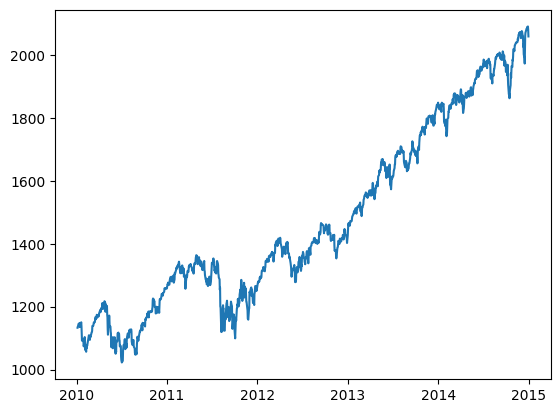

In [14]:
plt.plot(special_data)

In [14]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(special_data)

seq_length = 10
x, y = sliding_windows(training_data, seq_length)

train_size = 160
val_size = 90
test_size = 40

dataX = Variable(torch.Tensor(np.array(x)).to(device))
dataY = Variable(torch.Tensor(np.array(y)).to(device))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])).to(device))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])).to(device))

testX = Variable(torch.Tensor(np.array(x[train_size:train_size + test_size])).to(device))
testY = Variable(torch.Tensor(np.array(y[train_size:train_size + test_size])).to(device))

valX = Variable(torch.Tensor(np.array(x[train_size + test_size:train_size + test_size + val_size])).to(device))
valY = Variable(torch.Tensor(np.array(y[train_size + test_size:train_size + test_size + val_size])).to(device))

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = TimeSeriesDataset(trainX, trainY)
test_dataset = TimeSeriesDataset(testX, testY)
val_dataset = TimeSeriesDataset(valX, valY)

train_loader = DataLoader(train_dataset, batch_size = 10, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 10, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = 10, shuffle = False)

In [16]:
import torch.nn as nn

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

Epoch [1/1100], Train Loss: 0.0091, Valid Loss: 0.0118
Epoch [11/1100], Train Loss: 0.0026, Valid Loss: 0.0007
Epoch [21/1100], Train Loss: 0.0019, Valid Loss: 0.0018
Epoch [31/1100], Train Loss: 0.0020, Valid Loss: 0.0024
Epoch [41/1100], Train Loss: 0.0018, Valid Loss: 0.0014
Epoch [51/1100], Train Loss: 0.0018, Valid Loss: 0.0015
Epoch [61/1100], Train Loss: 0.0017, Valid Loss: 0.0017
Epoch [71/1100], Train Loss: 0.0016, Valid Loss: 0.0014
Epoch [81/1100], Train Loss: 0.0015, Valid Loss: 0.0014
Epoch [91/1100], Train Loss: 0.0014, Valid Loss: 0.0012
Epoch [101/1100], Train Loss: 0.0012, Valid Loss: 0.0010
Epoch [111/1100], Train Loss: 0.0008, Valid Loss: 0.0006
Epoch [121/1100], Train Loss: 0.0006, Valid Loss: 0.0004
Epoch [131/1100], Train Loss: 0.0005, Valid Loss: 0.0004
Epoch [141/1100], Train Loss: 0.0005, Valid Loss: 0.0004
Epoch [151/1100], Train Loss: 0.0005, Valid Loss: 0.0003
Epoch [161/1100], Train Loss: 0.0005, Valid Loss: 0.0003
Epoch [171/1100], Train Loss: 0.0005, Vali

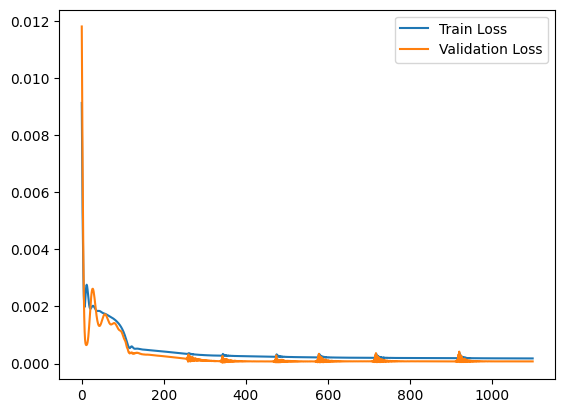

In [17]:
num_epochs = 1100
learning_rate = 0.001

input_size = 1
hidden_size = 64 # need to find correct value; 40 small, 64 norm, 100 a lot
num_layers = 1

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

# Define loss and optimizer
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)

train_loss = []
valid_loss = []

for epoch in range(num_epochs):
    # set the model to train mode
    model.train()

    # forward pass
    output = model(trainX)
    loss = criterion(output, trainY)

    # backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # calculate training loss
    train_loss.append(loss.item())

    # set the model to evaluation mode
    model.eval()

    # calculate validation loss
    with torch.no_grad():
        output = model(testX)
        loss = criterion(output, testY)
        valid_loss.append(loss.item())

    # print progress
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'.format(
            epoch+1, num_epochs, train_loss[-1], valid_loss[-1]))

# plot train and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error
# Test the model
model.eval()
test_predict = model(testX)

test_predict_inv = sc.inverse_transform(test_predict.cpu().detach().numpy())
testY_inv = sc.inverse_transform(testY.cpu().detach().numpy())

test_score = np.sqrt(mean_squared_error(testY_inv, test_predict_inv))
print("Test RMSE Score: %.2f" % test_score)

Test RMSE Score: 9.31


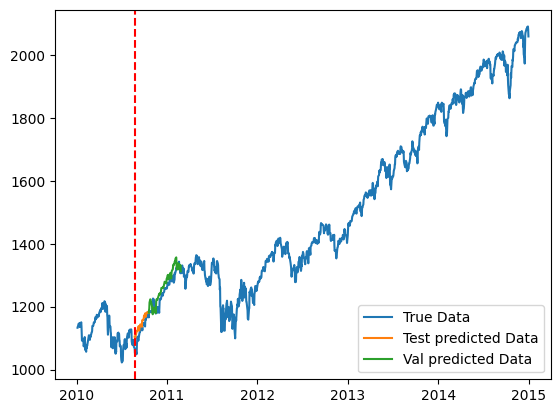

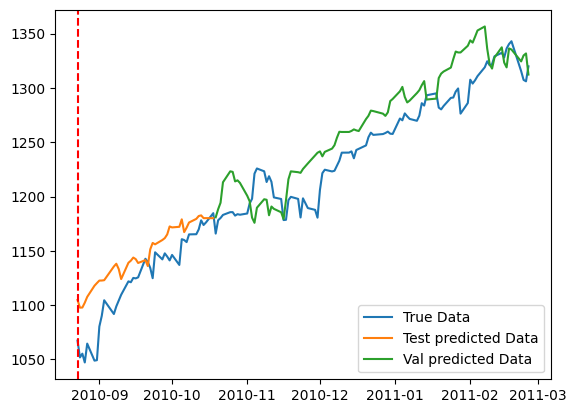

In [19]:
import matplotlib.pyplot as plt

# make predictions
predY_test = model(testX)
predY_val = model(valX)

# invert scaling for forecast
predY_test_inv = sc.inverse_transform(predY_test.cpu().detach().numpy())
predY_val_inv = sc.inverse_transform(predY_val.cpu().detach().numpy())
testY_inv = sc.inverse_transform(testY.cpu().detach().numpy())
# plot 1
plt.plot(special_data, label='True Data')
plt.plot(special_data.index[train_size: train_size + test_size], predY_test_inv, label = 'Test predicted Data')
plt.plot(special_data.index[train_size + test_size:train_size + test_size + val_size], predY_val_inv, label='Val predicted Data')
plt.axvline(x=special_data.index[train_size], c='r', linestyle='--')
plt.legend()
plt.show()
# plot 2
plt.plot(special_data.index[train_size: train_size + test_size+ val_size], \
         special_data.Price[train_size: train_size + test_size+ val_size], label='True Data')
plt.plot(special_data.index[train_size: train_size + test_size], predY_test_inv, label='Test predicted Data')
plt.plot(special_data.index[train_size + test_size:train_size + test_size + val_size], predY_val_inv, label='Val predicted Data')
plt.axvline(x = special_data.index[train_size], c='r', linestyle='--')
plt.legend()
plt.show()

## Инициализация

In [45]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)


class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Чтение входных данных

### Загрузка данных

In [159]:
data = pd.read_csv("..\..\Data\Day\\nasdaq_Linear.csv", index_col = 0)

### Трансформация данных

In [ ]:
def data_transformer():
    data = data.replace(",", "", regex=True)
    data.Date = pd.to_datetime(data.Date)
    data = data.sort_values(by=["Date"])
    data.set_index('Date')
    data.Price = data.Price.astype(float)
    data.High = data.High.astype(float)
    data.Low = data.Low.astype(float)
    data.Open = data.Open.astype(float)
    data["Vol."] = data["Vol."].astype(float)

def data_transformer_alter():
    data = data.replace(",", "", regex=True)
    data.Date = pd.to_datetime(data.Date)
    data = data.sort_values(by=["Date"])
    data.set_index('Date')
    data.Close = data.Close.astype(float)
    data.High = data.High.astype(float)
    data.Low = data.Low.astype(float)
    data.Open = data.Open.astype(float)
    data["Vol"] = data["Vol"].astype(float)

In [160]:
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.set_index('Date')
data.Close = data.Close.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)
data["Vol"] = data["Vol"].astype(float)

In [161]:
data.head()

,Date,Open,High,Low,Close,Vol
0,2010-01-04,20.2400,20.25,20.22,20.22,63202.0
1,2010-01-05,20.2902,20.30,20.28,20.28,24691.0
2,2010-01-06,20.2800,20.29,20.27,20.29,12756.0
3,2010-01-07,20.0200,20.03,20.01,20.01,40267.0
4,2010-01-08,20.1900,20.22,20.19,20.22,20207.0


In [162]:
data.index = data.index[::-1]

In [163]:
data.head()

,Date,Open,High,Low,Close,Vol
1457,2010-01-04,20.2400,20.25,20.22,20.22,63202.0
1456,2010-01-05,20.2902,20.30,20.28,20.28,24691.0
1455,2010-01-06,20.2800,20.29,20.27,20.29,12756.0
1454,2010-01-07,20.0200,20.03,20.01,20.01,40267.0
1453,2010-01-08,20.1900,20.22,20.19,20.22,20207.0


In [164]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2015-01-01')]
special_data.index = data.index[:len(special_data)]

In [165]:
special_data.head()

,Date,Open,High,Low,Close,Vol
1457,2010-01-04,20.2400,20.25,20.22,20.22,63202.0
1456,2010-01-05,20.2902,20.30,20.28,20.28,24691.0
1455,2010-01-06,20.2800,20.29,20.27,20.29,12756.0
1454,2010-01-07,20.0200,20.03,20.01,20.01,40267.0
1453,2010-01-08,20.1900,20.22,20.19,20.22,20207.0


In [166]:
#change indexes
special_data.set_index('Date', inplace=True)

In [167]:
special_data = special_data.drop(columns=['Open', 'High', 'Low', 'Vol'])
special_data.rename(columns = {'Close':'Price'}, inplace = True)

In [168]:
special_data.head()

,Price
Date,
2010-01-04,20.22
2010-01-05,20.28
2010-01-06,20.29
2010-01-07,20.01
2010-01-08,20.22


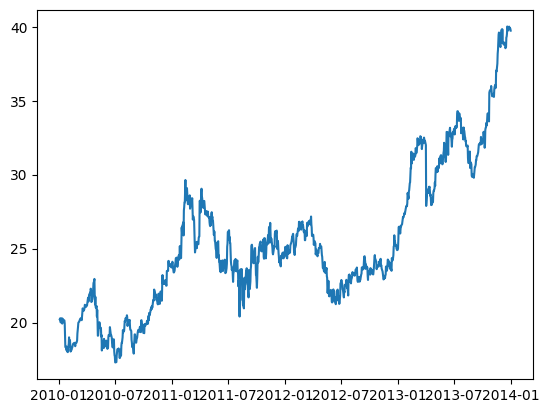

In [169]:
plt.plot(special_data)

## Начало расчёта

### Создаём наш объект для хранения результатов

In [170]:
forecasts = pd.DataFrame(columns = \
                         ['begin_date', 
                          'end_date', 
                          'window_size', 
                          'forecast_days', 
                          'forecast_precision'])

### Задаём все параметры симуляции и моделей

In [171]:
# Размер окна и размер прогноза
window_size = 200
forecast_days = 90
# гиперпараметры
num_epochs = 400
learning_rate = 0.001
input_size = 1
hidden_size = 64 # need to find correct value; 40 small, 64 norm, 100 a lot
num_layers = 1
num_classes = 1

### Обучаем модель, прогнозируем и сохраняем результат

In [172]:
import sys

sim_len = len(special_data) - window_size - forecast_days - val_size
prev_percent = 0
# начинаем симуляцию
for i in range(0, sim_len):
    percent = int(100 * (i + 1) / sim_len)

    if percent > prev_percent:
        prev_percent = percent
        sys.stdout.write(f"\rПрогресс: {percent}%")
        sys.stdout.flush()
    
    seq_length = 10

    window = special_data[i:i + window_size + forecast_days + 1 + seq_length]
    actual_values = special_data['Price'][i + window_size:i + window_size + forecast_days]
    # Переводим наши данные в тензора на наш расчётный девайс
    sc = MinMaxScaler()
    training_data = sc.fit_transform(window)

    x, y = sliding_windows(training_data, seq_length)

    train_size = int(0.8 * window_size)
    val_size = forecast_days
    test_size = int(0.2 * window_size)

    dataX = Variable(torch.Tensor(np.array(x)).to(device))
    dataY = Variable(torch.Tensor(np.array(y)).to(device))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])).to(device))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])).to(device))

    testX = Variable(torch.Tensor(np.array(x[train_size:train_size + test_size])).to(device))
    testY = Variable(torch.Tensor(np.array(y[train_size:train_size + test_size])).to(device))

    valX = Variable(torch.Tensor(np.array(x[train_size + test_size:train_size + test_size + val_size])).to(device))
    valY = Variable(torch.Tensor(np.array(y[train_size + test_size:train_size + test_size + val_size])).to(device))  
    
    #  Создаём классы для наших датасетов
    train_dataset = TimeSeriesDataset(trainX, trainY)
    test_dataset = TimeSeriesDataset(testX, testY)
    val_dataset = TimeSeriesDataset(valX, valY)

    train_loader = DataLoader(train_dataset, batch_size = 10, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size = 10, shuffle = False)
    val_loader = DataLoader(val_dataset, batch_size = 10, shuffle = False)

    # Создаём модель 

    model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

    # Define loss and optimizer
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)

    train_loss = []
    valid_loss = []
    for epoch in range(num_epochs):
        # set the model to train mode
        model.train()

        # forward pass
        output = model(trainX)
        loss = criterion(output, trainY)

        # backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate training loss
        train_loss.append(loss.item())

        # set the model to evaluation mode
        model.eval()

        # calculate validation loss
        with torch.no_grad():
            output = model(testX)
            loss = criterion(output, testY)
            valid_loss.append(loss.item())

    predY_val = model(valX)
    predY_val_inv = sc.inverse_transform(predY_val.cpu().detach().numpy()).ravel()
    percentage_error = ((predY_val_inv - actual_values) / actual_values) * 100
    result = {
                'begin_date': window.index[0],
                'end_date': window.index[-(forecast_days + val_size + 1)],
                'window_size': window_size,
                'forecast_days': forecast_days,
                'forecast_precision': np.mean(np.abs(percentage_error))
            }
    forecasts = pd.concat([forecasts, pd.DataFrame([result])], ignore_index = True)

C:\Users\Skiv2\AppData\Local\Temp\ipykernel_21916\3595380643.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forecasts = pd.concat([forecasts, pd.DataFrame([result])], ignore_index = True)


Прогресс: 100%

In [173]:
# Преобразуйте столбец 'forecast_precision' к типу данных float
forecasts['forecast_precision'] = pd.to_numeric(forecasts['forecast_precision'], errors='coerce')

# Получите 10 строк с наименьшими значениями в столбце 'forecast_precision'
top_10_rows = forecasts.nsmallest(10, 'forecast_precision', 'all')

In [174]:
top_10_rows

,begin_date,end_date,window_size,forecast_days,forecast_precision
733,2012-01-07,2012-05-06,200,90,1.477070
1015,2012-10-15,2013-02-12,200,90,1.478161
726,2011-12-31,2012-04-29,200,90,1.536255
724,2011-12-29,2012-04-27,200,90,1.547412
1016,2012-10-16,2013-02-13,200,90,1.563508
1017,2012-10-17,2013-02-14,200,90,1.567781
1014,2012-10-14,2013-02-11,200,90,1.572311
719,2011-12-24,2012-04-22,200,90,1.581964
743,2012-01-17,2012-05-16,200,90,1.583582
742,2012-01-16,2012-05-15,200,90,1.588067


In [175]:
# Сортировка по forecast_precision и получение первых 10 строк
sorted_result = forecasts.sort_values(by='forecast_precision').head(10)

# Вывод результата
print(sorted_result)

     begin_date   end_date window_size forecast_days  forecast_precision
733  2012-01-07 2012-05-06         200            90            1.477070
1015 2012-10-15 2013-02-12         200            90            1.478161
726  2011-12-31 2012-04-29         200            90            1.536255
724  2011-12-29 2012-04-27         200            90            1.547412
1016 2012-10-16 2013-02-13         200            90            1.563508
1017 2012-10-17 2013-02-14         200            90            1.567781
1014 2012-10-14 2013-02-11         200            90            1.572311
719  2011-12-24 2012-04-22         200            90            1.581964
743  2012-01-17 2012-05-16         200            90            1.583582
742  2012-01-16 2012-05-15         200            90            1.588067


In [176]:
result_df = forecasts.groupby(['forecast_days'])['forecast_precision'].mean().reset_index()

In [177]:
print(result_df)

   forecast_days  forecast_precision
0             90            3.439067


In [178]:
forecasts.to_csv('lstm_nasdaq.csv')